In [1]:
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"
import sys
from utils.tools import load_obj, save_obj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

In [2]:
def iewt1d(ewt,mfb):
    real = all(np.isreal(ewt[0]))
    if real:
        rec = np.zeros(len(ewt[0]))
        for i in range(0,len(ewt)):
            rec += np.real(np.fft.ifft(np.fft.fft(ewt[i])*mfb[i]))
    else:
        rec = np.zeros(len(ewt[0]))*0j
        for i in range(0,len(ewt)):
            rec += np.fft.ifft(np.fft.fft(ewt[i])*mfb[i])
    return rec

In [3]:
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))
def metircs(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    mape = MAPE(pred, true)
    return {"rmse":rmse, "r2":r2, "mape":mape}

## 数据加载

In [4]:
df = pd.read_csv("./data/data.csv", index_col=[0])
N = 3
cols = ["mean CPU usage rate"]
df.head()
metrics_dict = {}

,mean CPU usage rate,mean CPU usage rate0,mean CPU usage rate1,mean CPU usage rate2,mean CPU usage rate0_mfb,mean CPU usage rate1_mfb,mean CPU usage rate2_mfb
start time,,,,,,,
600000000,2198.091622,2518.076507,-252.943854,-261.875273,1.000000,0.000000,0.0
900000000,2250.400701,2517.786866,-253.476863,-226.011745,1.000000,0.000035,0.0
1200000000,2253.081158,2517.498542,-253.982418,-201.975521,0.991193,0.132426,0.0
1500000000,2894.839844,2517.211536,-254.460350,419.047463,0.707107,0.707107,0.0
1800000000,2713.987208,2516.925844,-254.910493,255.571477,0.132426,0.991193,0.0


## lstm-ewt 预测

In [5]:
# 不同horizon下的分量预测结果
lstmewt_horizon_dict = {}
for hn in range(1, 21):
    # 加载不同horizon下的各分量预测结果
    pred_lst = []
    # true_lst = []
    for i in range(N):
        true, pred = load_obj(f"./results/google1/lstm_google1_ftS_sl80_ll0_pl1_is1_os1_hn{hn}_bs32_lr0.001_mean CPU usage rate{i}_0/true_pred.pkl")
        # true_lst.append(true)
        pred_lst.append(pred)
    pred_lstm = np.concatenate(pred_lst,axis=-1)
    # true_lstm = np.concatenate(true_lst, axis=-1)
    lstmewt_horizon_dict[hn] = pred_lstm

In [6]:
target_horizon = 1
lstmewt_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    pred_len = 1
    seq_len = 80
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    total_len = len(df)
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values
        # seq_len部分的ewt
        pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
        # 和预测得到的ewt组合
        pred_horizon = lstmewt_horizon_dict[horizon][:,0,:]
        # pred_horizon = pred_lstm[:,target_horizon-1,:]]
        ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
        # 重构
        reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
        target = df[col]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = reconstruction[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test)
        
        lstmewt_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        lstmewt_target_horizon_data = [target, reconstruction, ewt_pred]
trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
lstmewt_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict["lstmewt"] = pd.DataFrame(lstmewt_metrics).T

In [7]:
metrics_dict["lstmewt"]

,rmse,r2,mape
horizon1,318.847816,0.836180,0.070567
horizon2,333.150760,0.821153,0.077683
horizon3,357.557247,0.793989,0.085352
horizon4,379.592943,0.767647,0.091947
horizon5,384.095609,0.762102,0.094088
horizon6,385.022892,0.760952,0.096392
horizon7,391.346044,0.753036,0.098423
horizon8,396.305774,0.746736,0.100065
horizon9,410.581040,0.727973,0.103358
horizon10,410.376996,0.728244,0.102730


### target_horizon展示

In [8]:
target, reconstruction, ewt_pred = lstmewt_target_horizon_data
gap = target_horizon - 1

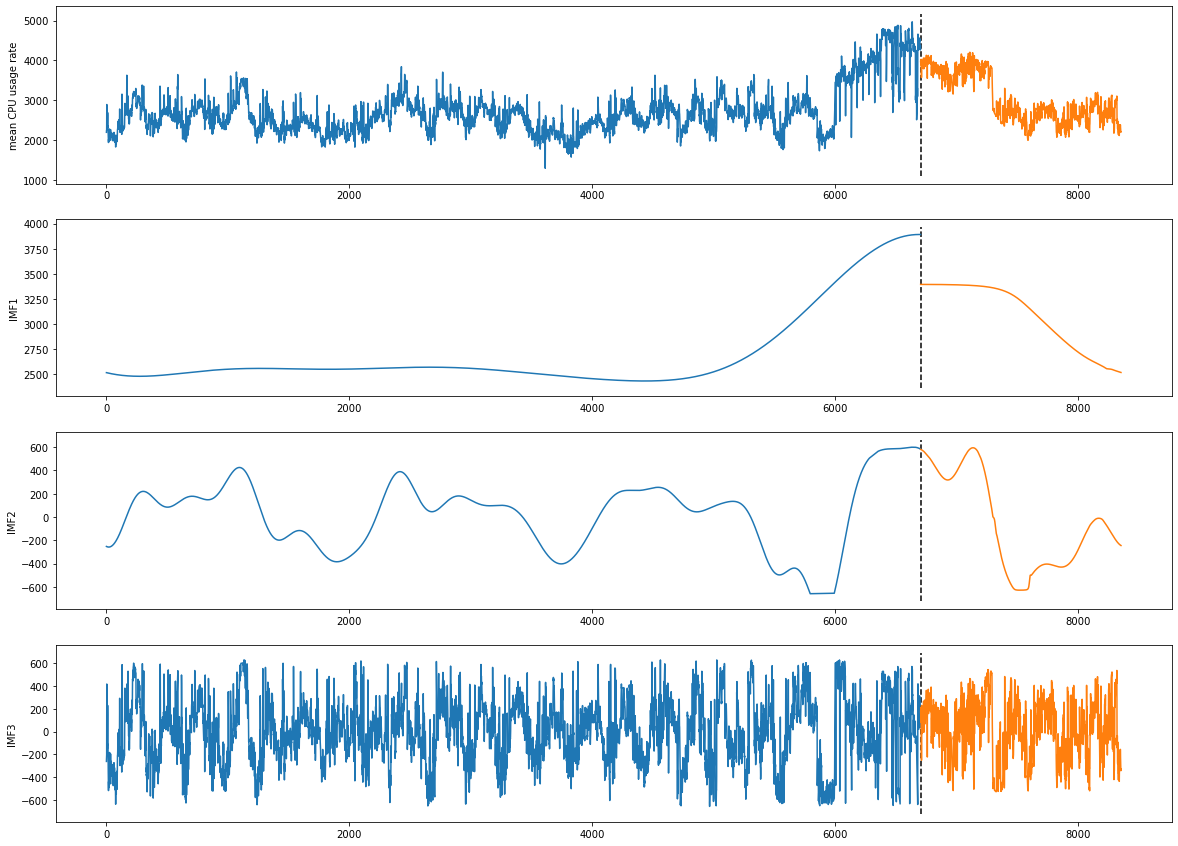

In [9]:
for col in cols:
    _ = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
    _ = plt.plot(range(pred_startpoint, len(df)), reconstruction[pred_startpoint:])
    ax = plt.gca()
    _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
    _ = plt.ylabel(f"{col}");
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
        _ = plt.plot(range(pred_startpoint, len(df)), ewt_pred[:, i][pred_startpoint:])
        ax = plt.gca()
        _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
        _ = plt.ylabel(f"IMF{i+1}");

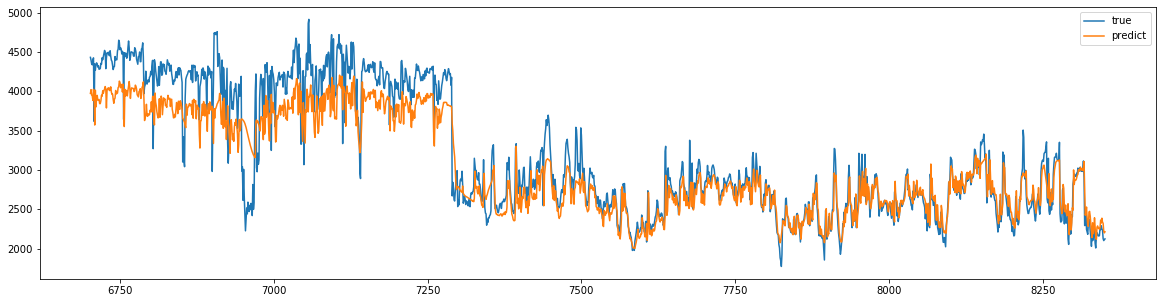

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(range(pred_startpoint, len(df)), target.values[pred_startpoint:], label="true")
plt.plot(range(pred_startpoint, len(df)), reconstruction[pred_startpoint:], label="predict")
plt.legend();

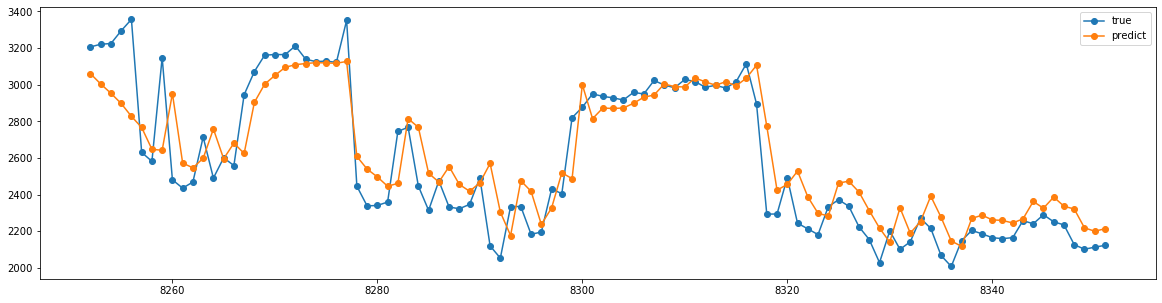

In [11]:
plt.figure(figsize=(20, 5))
select_length = 100
plt.plot(range(len(df)-select_length, len(df)), target.values[-select_length:], '-o', label="true")
plt.plot(range(len(df)-select_length, len(df)), reconstruction[-select_length:], '-o', label="predict")
plt.legend();

## lstm 预测

In [12]:
lstm_horizon_dict = {}
for hn in range(1, 21):
    true, pred = load_obj(f"./results/google1/lstm_google1_ftS_sl80_ll0_pl1_is1_os1_hn{hn}_bs32_lr0.001_mean CPU usage rate_0/true_pred.pkl")
    lstm_horizon_dict[hn] = pred

In [13]:
target_horizon = 1
lstm_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    pred_len = 1
    seq_len = 80
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    total_len = len(df)
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        # seq_len部分的col
        pre_col = df.iloc[:pre_len][[col]]
        # 和预测得到的col组合
        pred_horizon = lstm_horizon_dict[horizon][:,0,:]
        pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
        target = df[col]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = pred_horizon[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test.flatten())
        
        lstm_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        lstm_target_horizon_data = [target, pred_horizon]
    
trues_test_all, preds_test_all = np.concatenate(trues_test_lst), np.concatenate(preds_test_lst)
lstm_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict["lstm"] = pd.DataFrame(lstm_metrics).T

In [14]:
metrics_dict["lstm"]

,rmse,r2,mape
horizon1,264.795106,0.887015,0.258650
horizon2,398.765182,0.743768,0.239092
horizon3,417.452350,0.719190,0.239588
horizon4,425.104549,0.708590,0.238168
horizon5,465.647278,0.650356,0.230526
horizon6,505.850787,0.587373,0.229961
horizon7,489.644731,0.613389,0.233178
horizon8,515.725038,0.571107,0.228275
horizon9,500.386866,0.595959,0.229969
horizon10,524.757940,0.555643,0.226453


autoformer节为former节的具体实现

## autoformer-ewt 预测

In [15]:
autoewt_pred_lst = []
for i in range(N):
    true_auto, pred_auto = load_obj(f"./results/google1/autoformer_google1_ftS_sl80_ll10_pl20_is1_os1_hn1_bs32_lr0.0001_mean CPU usage rate{i}_0/true_pred.pkl")
    autoewt_pred_lst.append(pred_auto)
autoewt_pred = np.concatenate(autoewt_pred_lst,axis=-1)    

In [16]:
target_horizon = 1
autoewt_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    pred_len = 20
    seq_len = 80
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    total_len = len(df)
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        # autoformer多步预测时，截断了最后horizon个步长，为了对齐，要截断
        align_len = pred_len-horizon
        align_len = -total_len if align_len<=0 else align_len
        tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values[:-align_len]
        # seq_len部分的ewt
        pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
        # 和预测得到的ewt组合
        pred_horizon = autoewt_pred[:,horizon-1,:]
        ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
        # 重构
        reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
        target = df[col][:-align_len]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = reconstruction[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test)
        
        autoewt_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        autoewt_target_horizon_data = [target, reconstruction, ewt_pred]
trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
autoewt_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict["autoewt"] = pd.DataFrame(autoewt_metrics).T

In [17]:
metrics_dict["autoewt"]

,rmse,r2,mape
horizon1,479.318008,0.631582,0.108074
horizon2,503.280554,0.593596,0.117417
horizon3,500.270121,0.598318,0.117526
horizon4,497.836268,0.602285,0.117911
horizon5,495.719293,0.605661,0.118508
horizon6,494.409201,0.607585,0.119340
horizon7,492.014942,0.611217,0.119562
horizon8,492.368733,0.610533,0.120550
horizon9,494.937274,0.606338,0.121746
horizon10,496.808272,0.603115,0.122599


### target_horizon展示

In [19]:
target, reconstruction, ewt_pred = autoewt_target_horizon_data
gap = target_horizon-1

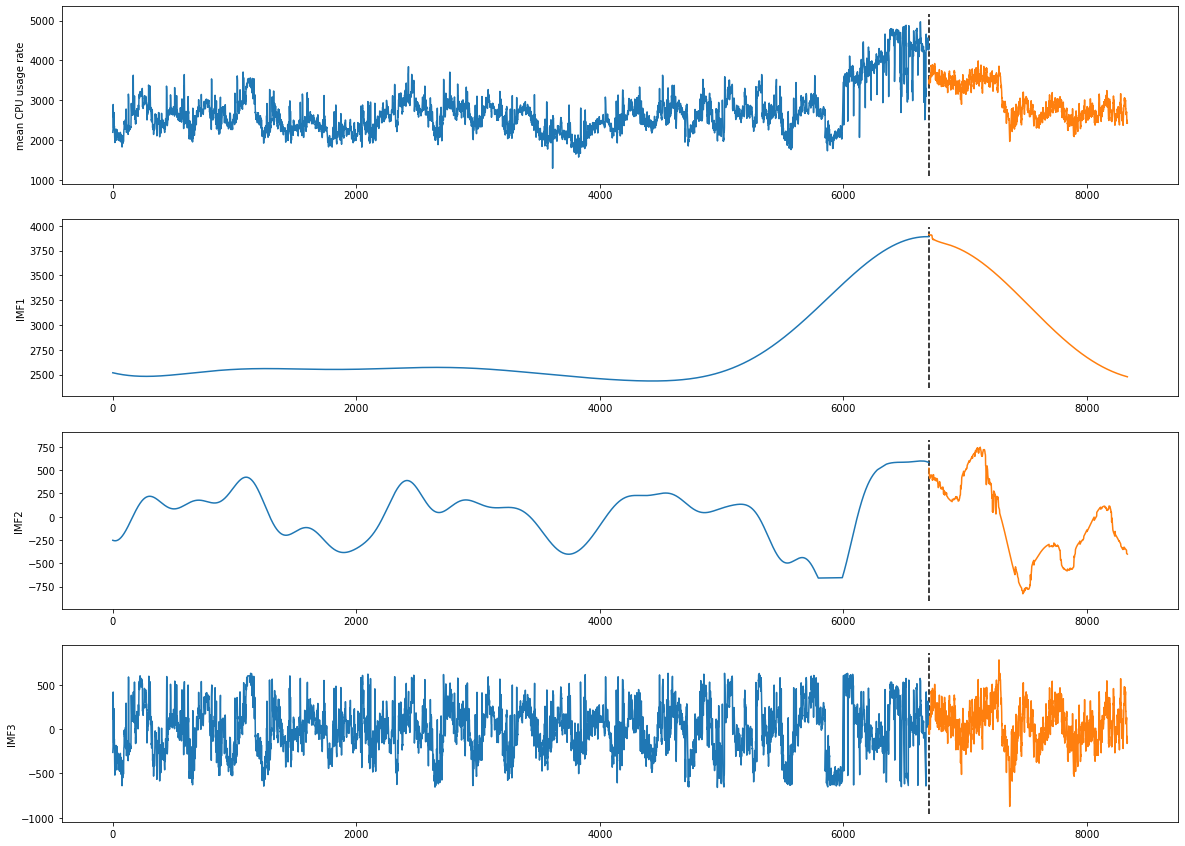

In [20]:
for col in cols:
    _ = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
    _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:])
    ax = plt.gca()
    _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
    _ = plt.ylabel(f"{col}");
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
        _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), ewt_pred[:, i][pred_startpoint:])
        ax = plt.gca()
        _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
        _ = plt.ylabel(f"IMF{i+1}");

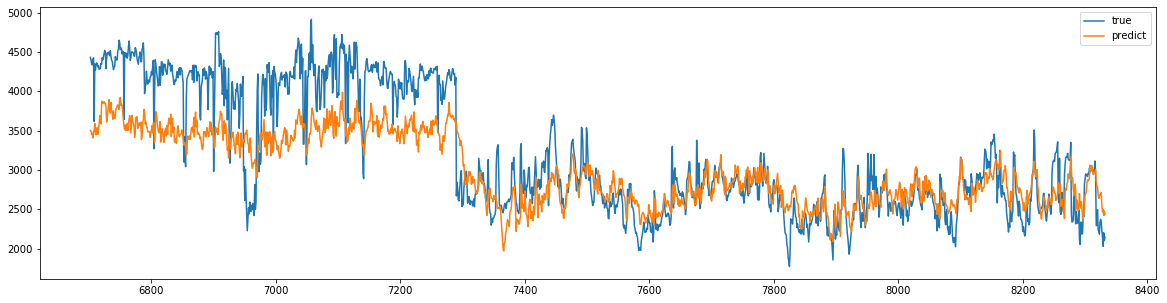

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), target.values[pred_startpoint:], label="true")
plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:], label="predict")
plt.legend();

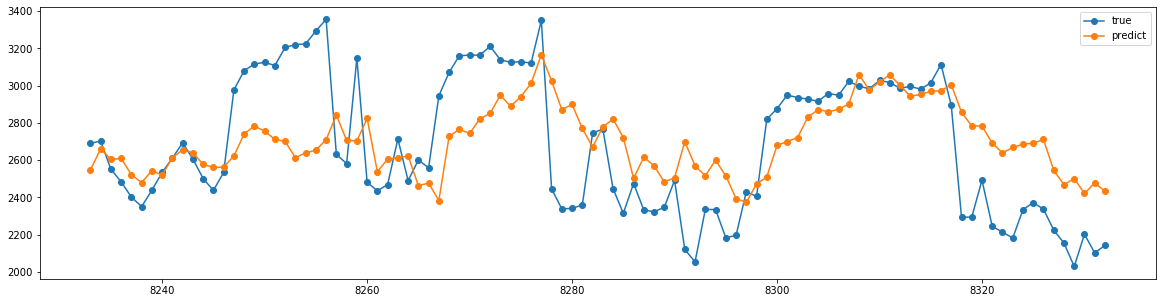

In [22]:
plt.figure(figsize=(20, 5))
select_length = 100
plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), target.values[-select_length:], '-o', label="true")
plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), reconstruction[-select_length:], '-o', label="predict")
plt.legend();

## autoformer预测

In [23]:
auto_true, auto_pred = load_obj(f"./results/google1/autoformer_google1_ftS_sl80_ll10_pl20_is1_os1_hn1_bs32_lr0.0001_mean CPU usage rate_0/true_pred.pkl")

In [24]:
target_horizon = 1
auto_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    pred_len = 20
    seq_len = 80
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    total_len = len(df)
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        align_len = pred_len-horizon
        align_len = -total_len if align_len<=0 else align_len
        # seq_len部分的col
        pre_col = df.iloc[:pre_len][[col]]
        # 和预测得到的col组合
        pred_horizon = auto_pred[:,horizon-1,:]
        pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
        target = df[col][:-align_len]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = pred_horizon[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test.flatten())
        
        auto_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        auto_target_horizon_data = [target, pred_horizon]

trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
auto_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict["auto"] = pd.DataFrame(auto_metrics).T

In [25]:
metrics_dict["auto"]

,rmse,r2,mape
horizon1,304.715619,0.851104,0.278962
horizon2,331.838532,0.823318,0.274780
horizon3,344.852082,0.809129,0.274899
horizon4,355.384198,0.797327,0.275105
horizon5,368.408347,0.782200,0.275545
horizon6,379.353000,0.768975,0.275709
horizon7,385.823061,0.760929,0.275956
horizon8,397.231587,0.746500,0.276671
horizon9,404.157279,0.737503,0.277232
horizon10,412.944814,0.725797,0.277803


## former-ewt 预测

In [37]:
model_name = "trans"

In [38]:
ewt_pred_lst = []
for i in range(N):
    true_, pred_ = load_obj(f"./results/google1/{model_name}former_google1_ftS_sl80_ll10_pl20_is1_os1_hn1_bs32_lr0.0001_mean CPU usage rate{i}_0/true_pred.pkl")
    ewt_pred_lst.append(pred_)
model_ewt_pred = np.concatenate(ewt_pred_lst,axis=-1)    

In [39]:
target_horizon = 1
ewt_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    pred_len = 20
    seq_len = 80
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    total_len = len(df)
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        # former多步预测时，截断了最后horizon个步长，为了对齐，要截断
        align_len = pred_len-horizon
        align_len = -total_len if align_len<=0 else align_len
        tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values[:-align_len]
        # seq_len部分的ewt
        pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
        # 和预测得到的ewt组合
        pred_horizon = model_ewt_pred[:,horizon-1,:]
        ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
        # 重构
        reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
        target = df[col][:-align_len]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = reconstruction[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test)
        
        ewt_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        ewt_target_horizon_data = [target, reconstruction, ewt_pred]
trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
ewt_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict[f"{model_name}ewt"] = pd.DataFrame(ewt_metrics).T

In [40]:
metrics_dict[f"{model_name}ewt"]

,rmse,r2,mape
horizon1,557.144937,0.502229,0.105105
horizon2,552.867777,0.509566,0.116897
horizon3,539.328169,0.533148,0.114302
horizon4,534.397837,0.541722,0.116096
horizon5,537.625665,0.536171,0.120565
horizon6,549.983859,0.514407,0.123631
horizon7,539.834507,0.531972,0.122836
horizon8,535.174058,0.539870,0.123613
horizon9,537.043758,0.536507,0.126184
horizon10,532.118742,0.544693,0.125423


### target_horizon展示

In [41]:
target, reconstruction, ewt_pred = ewt_target_horizon_data
gap = target_horizon-1

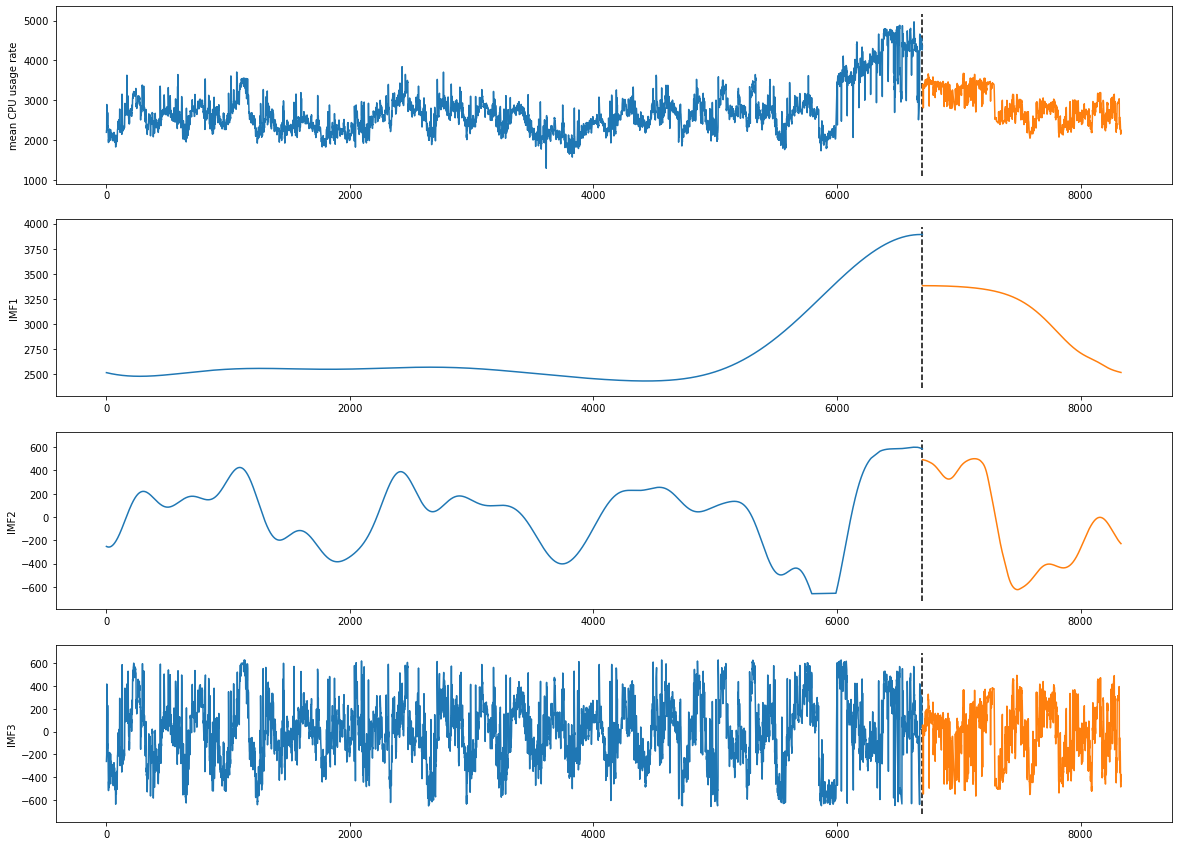

In [42]:
for col in cols:
    _ = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
    _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:])
    ax = plt.gca()
    _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
    _ = plt.ylabel(f"{col}");
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
        _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), ewt_pred[:, i][pred_startpoint:])
        ax = plt.gca()
        _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
        _ = plt.ylabel(f"IMF{i+1}");

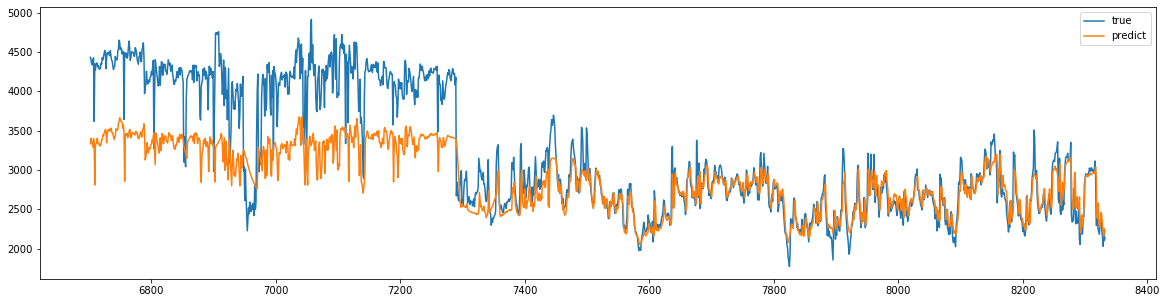

In [43]:
plt.figure(figsize=(20, 5))
plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), target.values[pred_startpoint:], label="true")
plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:], label="predict")
plt.legend();

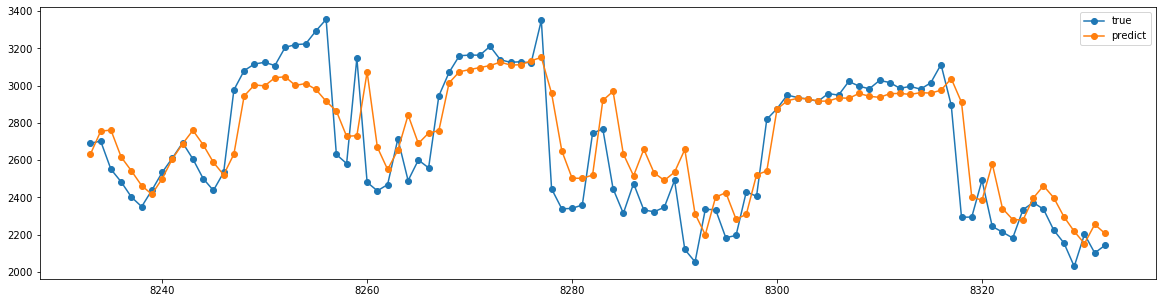

In [44]:
plt.figure(figsize=(20, 5))
select_length = 100
plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), target.values[-select_length:], '-o', label="true")
plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), reconstruction[-select_length:], '-o', label="predict")
plt.legend();

## former预测

In [45]:
_true, _pred = load_obj(f"./results/google1/{model_name}former_google1_ftS_sl80_ll10_pl20_is1_os1_hn1_bs32_lr0.0001_mean CPU usage rate_0/true_pred.pkl")

In [46]:
target_horizon = 1
_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    pred_len = 20
    seq_len = 80
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    total_len = len(df)
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        align_len = pred_len-horizon
        align_len = -total_len if align_len<=0 else align_len
        # seq_len部分的col
        pre_col = df.iloc[:pre_len][[col]]
        # 和预测得到的col组合
        pred_horizon = _pred[:,horizon-1,:]
        pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
        target = df[col][:-align_len]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = pred_horizon[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test.flatten())
        
        _metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        _target_horizon_data = [target, pred_horizon]

trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict[f"{model_name}"] = pd.DataFrame(_metrics).T

In [47]:
metrics_dict[f"{model_name}"]

,rmse,r2,mape
horizon1,547.449821,0.519402,0.221704
horizon2,532.076284,0.545760,0.224482
horizon3,543.885992,0.525224,0.223553
horizon4,584.445063,0.451866,0.217884
horizon5,559.963114,0.496827,0.221448
horizon6,590.914616,0.439440,0.217221
horizon7,578.836565,0.461901,0.218388
horizon8,588.821877,0.442996,0.216813
horizon9,601.729564,0.418130,0.215035
horizon10,685.145084,0.245164,0.203686


## arima rolling

In [48]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA,ARIMA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [53]:
def get_result(val_data, test_data, rolling=True):
    pred_len = 20
    result=list()
    history = [x for x in val_data[-600:, 0]]

    preds_lst = list()
    trues_lst = list()
    initial = True
    for t in tqdm(range(len(test_data[:, 0])-pred_len)):
        history = history[-600:]
        if initial:
            model = ARMA(history, order=(5, 0, 0))
            try:
                model_fit = model.fit()
            except:
                model_fit = model.fit(start_params=model_fit.params)
                
            # 仅估计一次模型，否则，滚动预测，迭代feed数据，重新估计模型
            if not rolling:
                initial = False
            
        output = model_fit.forecast(pred_len)
        yhat = output[0]
        preds_lst.append(yhat)
        obs = test_data[:, 0][t]
        history.append(obs)
        trues_lst.append(test_data[:, 0][t:t+pred_len])
    return preds_lst, trues_lst

In [50]:
val_size = int(len(df)*0.1)
test_size = int(len(df)*0.2)
ar_data = df[cols].values
train_data, val_data, test_data \
    = ar_data[:(len(df)-test_size-val_size)], ar_data[(len(df)-test_size-val_size):(len(df)-test_size)], ar_data[-test_size:]

In [51]:
# arma_model=ARMA(train_data[:, 0], order=(5, 0, 0))
# arma_result=arma_model.fit()
# arma_result.summary()

In [54]:
preds_lst, trues_lst = get_result(val_data, test_data, rolling=True)

  0%|          | 0/1650 [00:00<?, ?it/s]

E:\ANACONDA\Lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [55]:
ar_preds = np.stack(preds_lst, axis=0)
ar_trues = np.stack(trues_lst, axis=0)

ar_metrics = {}
for horizon in range(1, 21):
    ar_metrics[f"horizon{horizon}"] = metircs(ar_trues[:, horizon-1], ar_preds[:, horizon-1])
ar_metrics["allhorizon"] = metircs(ar_trues.flatten(), ar_preds.flatten())
metrics_dict["arima_rolling"] = pd.DataFrame(ar_metrics).T

In [57]:
metrics_dict["arima_rolling"]

,rmse,r2,mape
horizon1,201.499450,0.934928,0.041988
horizon2,260.486459,0.891191,0.060041
horizon3,290.684110,0.864425,0.069577
horizon4,312.439402,0.843323,0.076456
horizon5,331.932491,0.823193,0.082377
horizon6,349.263772,0.804248,0.087054
horizon7,364.081810,0.787200,0.091378
horizon8,376.847182,0.771923,0.094964
horizon9,386.744033,0.759709,0.097941
horizon10,396.124405,0.747834,0.100321


## arima static

In [64]:
preds_lst, trues_lst = get_result(val_data, test_data, rolling=False)

  0%|          | 0/1650 [00:00<?, ?it/s]

E:\ANACONDA\Lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [65]:
ar_preds = np.stack(preds_lst, axis=0)
ar_trues = np.stack(trues_lst, axis=0)

ar_metrics = {}
for horizon in range(1, 21):
    ar_metrics[f"horizon{horizon}"] = metircs(ar_trues[:, horizon-1], ar_preds[:, horizon-1])
ar_metrics["allhorizon"] = metircs(ar_trues.flatten(), ar_preds.flatten())
metrics_dict["arima_static"] = pd.DataFrame(ar_metrics).T

In [66]:
metrics_dict["arima_static"]

,rmse,r2,mape
horizon1,1522.620315,-2.715585,0.490541
horizon2,1505.965413,-2.636829,0.484634
horizon3,1469.113423,-2.462970,0.471358
horizon4,1435.662199,-2.308093,0.459457
horizon5,1405.160876,-2.168484,0.448775
horizon6,1380.425662,-2.057908,0.440377
horizon7,1357.683040,-1.959167,0.432800
horizon8,1337.544601,-1.873208,0.426261
horizon9,1319.702312,-1.797964,0.420627
horizon10,1304.050898,-1.732830,0.415878


## 模型评估

In [80]:
def evaluation_show(taget_indictor, target_horizon, sort=True):
    hist_dict = {}
    for key, value in metrics_dict.items():
        hist_dict[key] = value[taget_indictor][target_horizon]
    if sort:
        hist_dict = dict(sorted(hist_dict.items(), key=lambda x:x[1]))
    fig = plt.figure(figsize=(10, 6))
    x, width = 0, 0.25
    xtick_lst = []
    xlabel_lst = []
    for key, value in hist_dict.items():
        xtick_lst.append(x)
        xlabel_lst.append(key)
        plt.bar(x, value, width=width, label=key)
        x += width
    plt.xticks(xtick_lst, xlabel_lst)
    plt.title(f"{taget_indictor}_{target_horizon}")
    plt.legend();
    return fig, hist_dict

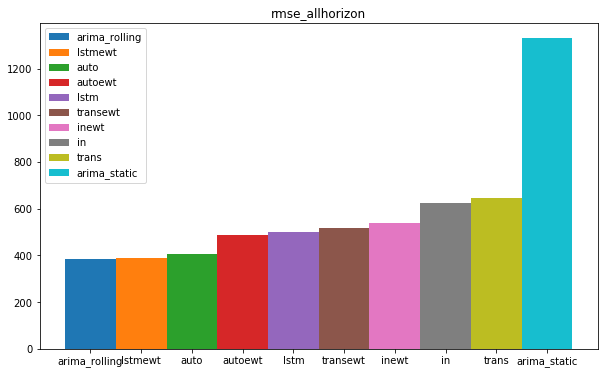

In [81]:
taget_indictor = 'rmse'
target_horizon = "allhorizon"
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

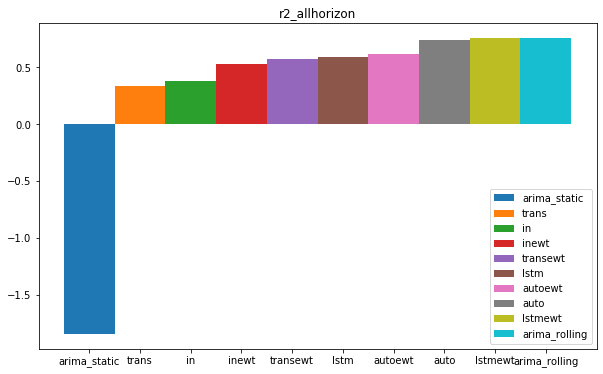

In [82]:
taget_indictor = 'r2'
target_horizon = "allhorizon"
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

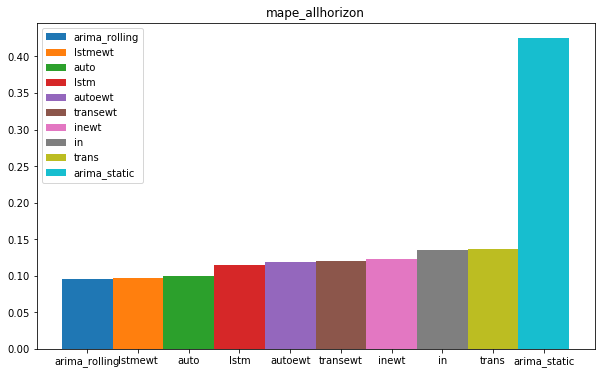

In [83]:
taget_indictor = 'mape'
target_horizon = "allhorizon"
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)